# Forecasting Regional Electricity Demand

{badge}`R,badge-primary` {badge}`forecasting,badge-secondary` {badge}`energy market,badge-warning` 

This post explores time series forecasting models for the 5-min regional electricity demand data from the Electricity Market of the Philippines.

## Setup

### Libraries

In [237]:
library(data.table)
library(forecast)
library(ggplot2)
library(ggforce)
library(rpart)
library(lubridate)

### Paths

In [80]:
filename = "/Volumes/data/projects/django-mms/data/demand_daily/luzon-hourly-demand.csv"

In [81]:
dt = fread(filename,sep=",")

In [82]:
head(dt)

TIME_INTERVAL,MKT_REQT,LOAD_BID,LOAD_CURTAILED,LOSSES,GENERATION,MKT_IMPORT,MKT_EXPORT
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-06-26 00:00:00,7763.500,320.0000,0,138.0200,8147.067,74.45909,0
2021-06-26 01:00:00,7887.279,466.6667,0,147.4142,8401.715,99.62167,0
2021-06-26 02:00:00,7527.432,480.0000,0,139.3717,7996.198,150.60667,0
2021-06-26 03:00:00,7326.856,480.0000,0,131.8258,7722.851,215.86000,0
2021-06-26 04:00:00,7104.273,480.0000,0,121.6275,7492.467,213.44250,0
2021-06-26 05:00:00,6941.924,480.0000,0,115.4933,7348.954,188.46833,0


In [83]:
n_date <- unique(dt[, TIME_INTERVAL])
length(n_date)

[1] 1201

In [84]:
dt_train <- dt[TIME_INTERVAL %in% n_date[1:1000]]
dt_test <- dt[TIME_INTERVAL %in% n_date[1001:1201]]
head(dt_test)

TIME_INTERVAL,MKT_REQT,LOAD_BID,LOAD_CURTAILED,LOSSES,GENERATION,MKT_IMPORT,MKT_EXPORT
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-08-06 16:00:00,9159.344,0,0,134.9275,9299.358,0.00000000,5.123333
2021-08-06 17:00:00,8681.993,0,0,120.0200,8827.621,0.02166667,25.593333
2021-08-06 18:00:00,8675.513,0,0,124.0275,8859.455,0.00000000,59.943333
2021-08-06 19:00:00,8907.350,0,0,131.9883,9071.607,0.00000000,32.282500
2021-08-06 20:00:00,8963.976,0,0,136.3025,9121.383,0.00000000,21.055833
2021-08-06 21:00:00,9022.061,0,0,142.3233,9158.010,8.20333333,1.846667


## Decomposition using STL

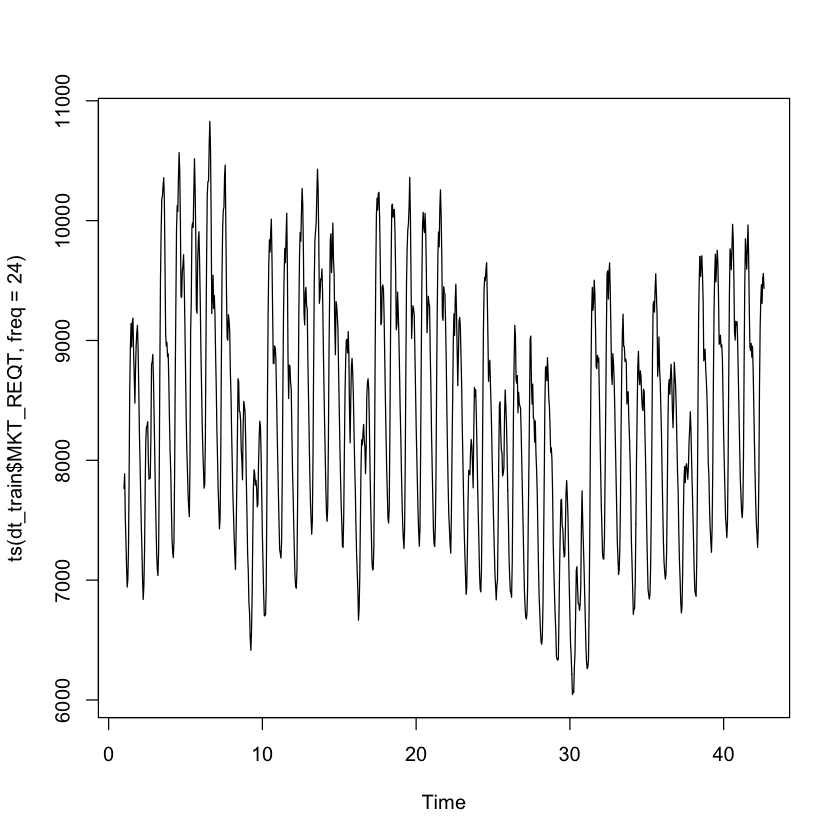

In [85]:
plot(ts(dt_train$MKT_REQT, freq = 24))

In [47]:
data_ts <- ts(dt_train$MKT_REQT, freq = 24*7)

decomp_ts <- stl(data_ts, s.window = "periodic", robust = TRUE)$time.series
 

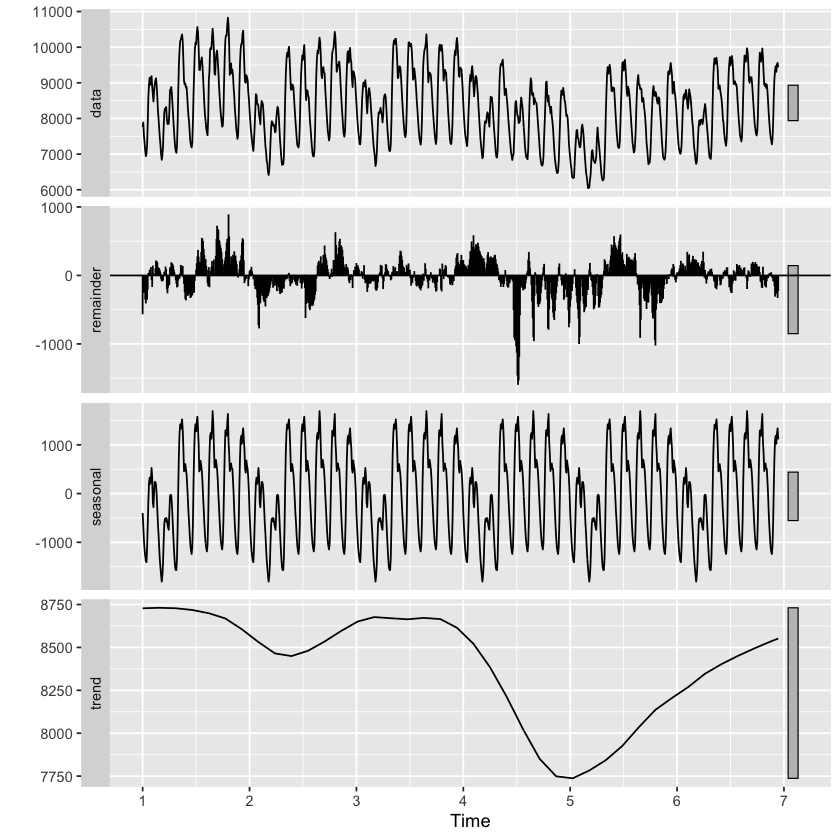

In [50]:
autoplot(stl(data_ts, s.window = "periodic", robust = TRUE))

### Exponential Models

In [54]:
fit = HoltWinters(data_ts, beta=FALSE, gamma=FALSE)


In [53]:
accuracy(fit)


ERROR: Error in accuracy.default(fit): First argument should be a forecast object or a time series.


In [55]:
fit

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = data_ts, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.9999262
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 9434.748

         Point Forecast    Lo 80     Hi 80    Lo 95    Hi 95
6.952381       9434.748 9045.771  9823.726 8839.859 10029.64
6.958333       9434.748 8884.672  9984.825 8593.479 10276.02
6.964286       9434.748 8761.053 10108.444 8404.420 10465.08

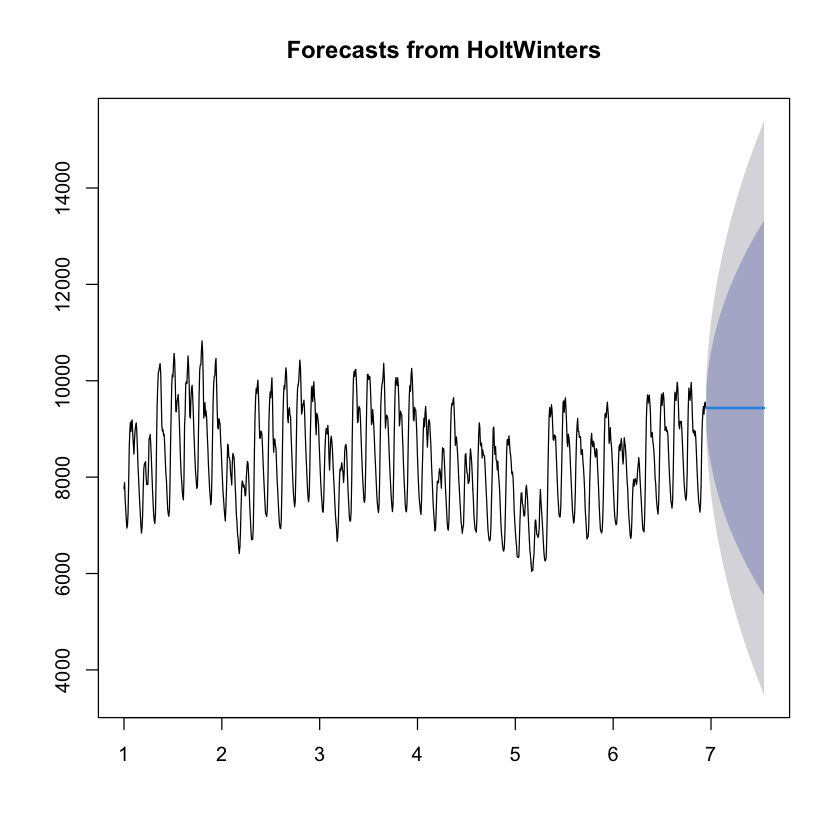

In [59]:
forecast(fit, 3)
plot(forecast(fit, 100))


### Arima

In [68]:
fit = arima(data_ts, order=c(p, d, q))

#accuracy(fit)

forecast(fit, 5)
plot(forecast(fit, 5))

ERROR: Error in arima(data_ts, order = c(p, d, q)): object 'p' not found


Warning message in ets(data_ts):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”


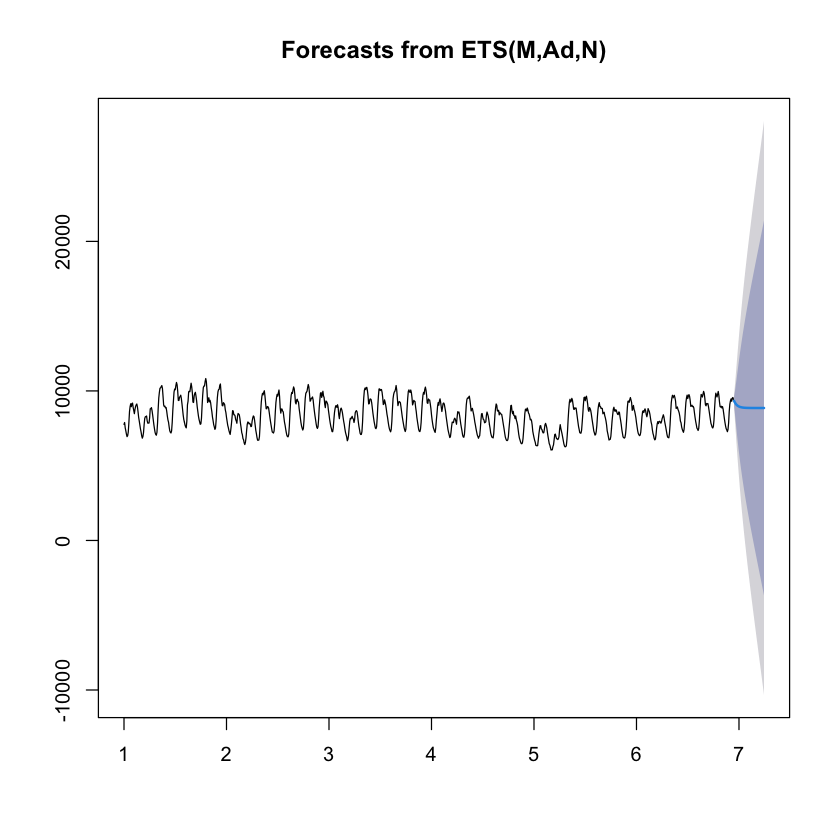

In [70]:
fit <- ets(data_ts)


plot(forecast(fit, 50))

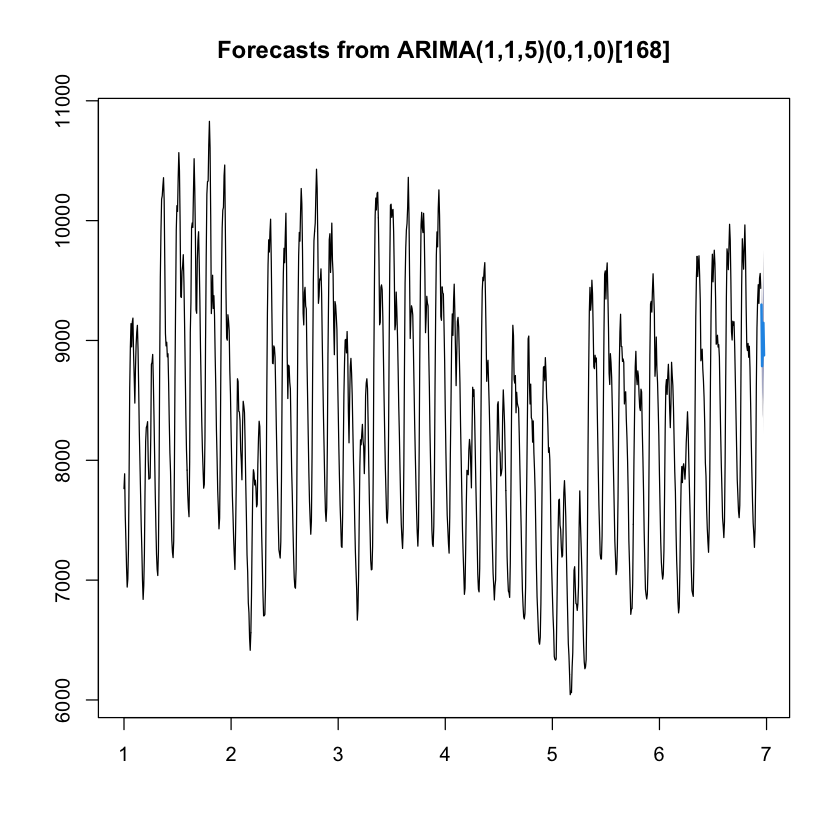

In [71]:
# Automated forecasting using an ARIMA model
fit <- auto.arima(data_ts)
plot(forecast(fit, 5))


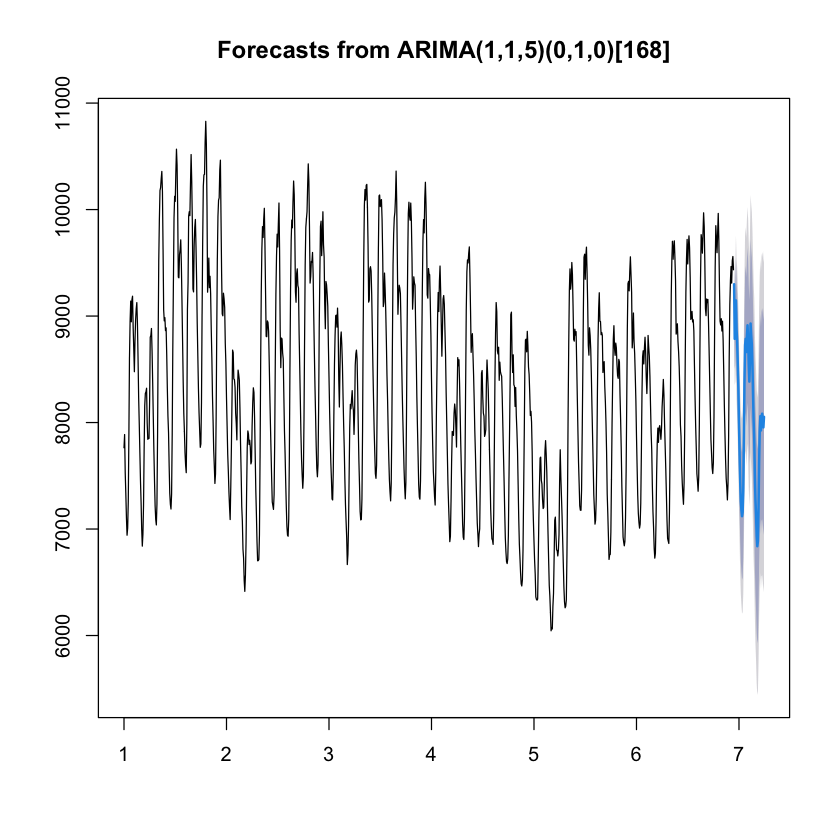

In [72]:
plot(forecast(fit, 50))

In [172]:
# remove last date
dt  <- dt[-nrow(dt),]


In [173]:
dt$TIME_INTERVAL  <-  ymd_hms(dt$TIME_INTERVAL)

In [174]:
dt$HOUR  <- hour(dt$TIME_INTERVAL) + 1

In [176]:
dt$WEEK_NUM  <-  as.numeric(strftime(as.Date(dt$TIME_INTERVAL, "%Y-%m-%d"), "%u"))

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
“unknown timezone '%Y-%m-%d'”


In [177]:
period  <- 24
N <- nrow(dt) # number of observations in the train set
window <- N / period # number of days in the train set
matrix_data <- data.table(Load = dt[, MKT_REQT],
                         Daily = rep(1:period, window),
                         Weekly = dt[, WEEK_NUM])



In [178]:
head(matrix_data)

Load,Daily,Weekly
<dbl>,<int>,<dbl>
7763.500,1,6
7887.279,2,6
7527.432,3,6
7326.856,4,6
7104.273,5,6
6941.924,6,6
7008.685,7,6
7254.535,8,6
7877.656,9,6


In [194]:
n_date <- unique(dt[, TIME_INTERVAL])


In [192]:
data_train <- dt[TIME_INTERVAL %in% n_date[1:1176]]
data_test <- dt[TIME_INTERVAL %in% n_date[1177:1200]]

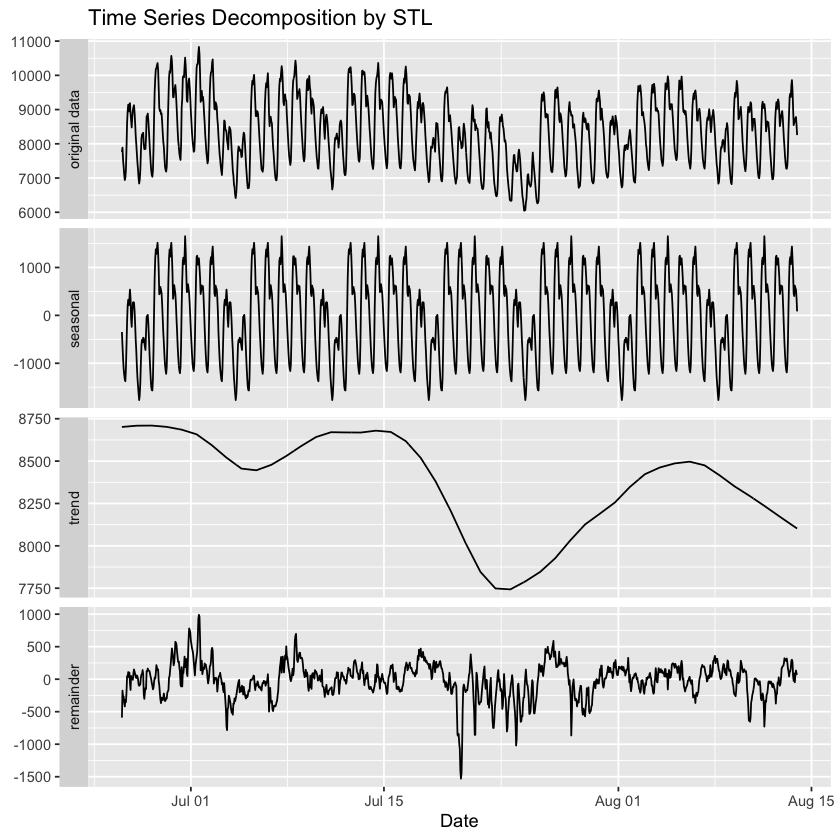

In [197]:
data_ts <- ts(data_train$MKT_REQT, freq = period * 7)
decomp_ts <- stl(data_ts, s.window = "periodic", robust = TRUE)$time.series
 
decomp_stl <- data.table(MKT_REQT = c(data_train$MKT_REQT, as.numeric(decomp_ts)),
                         TIME_INTERVAL = rep(data_train[,TIME_INTERVAL], ncol(decomp_ts)+1),
                         Type = factor(rep(c("original data", colnames(decomp_ts)),
                                       each = nrow(decomp_ts)),
                                       levels = c("original data", colnames(decomp_ts))))
 
ggplot(decomp_stl, aes(x = TIME_INTERVAL, y = MKT_REQT)) +
  geom_line() + 
  facet_grid(Type ~ ., scales = "free_y", switch = "y") +
  labs(x = "Date", y = NULL,
       title = "Time Series Decomposition by STL")

## Constructing features to model


In [200]:
# multiseasonal object
data_msts <- msts(data_train$MKT_REQT, seasonal.periods = c(period, period*7))


In [201]:
K <- 2
fuur <- fourier(data_msts, K = c(K, K))

In [203]:
# 2 pairs of sine and cosine values for daily and weekly season
head(fuur)

S1-24,C1-24,S2-24,C2-24,S1-168,C1-168,S2-168,C2-168
0.2588190,0.9659258,0.5000000,0.8660254,0.03739119,0.9993007,0.07473009,0.9972038
0.5000000,0.8660254,0.8660254,0.5000000,0.07473009,0.9972038,0.14904227,0.9888308
0.7071068,0.7071068,1.0000000,0.0000000,0.11196448,0.9937122,0.22252093,0.9749279
0.8660254,0.5000000,0.8660254,-0.5000000,0.14904227,0.9888308,0.29475517,0.9555728
0.9659258,0.2588190,0.5000000,-0.8660254,0.18591161,0.9825665,0.36534102,0.9308737
1.0000000,0.0000000,0.0000000,-1.0000000,0.22252093,0.9749279,0.43388374,0.9009689


In [204]:
# forecasting the trend from STL
trend_part <- ts(decomp_ts[,2])
trend_fit <- auto.arima(trend_part)
trend_for <- forecast(trend_fit, period)$mean

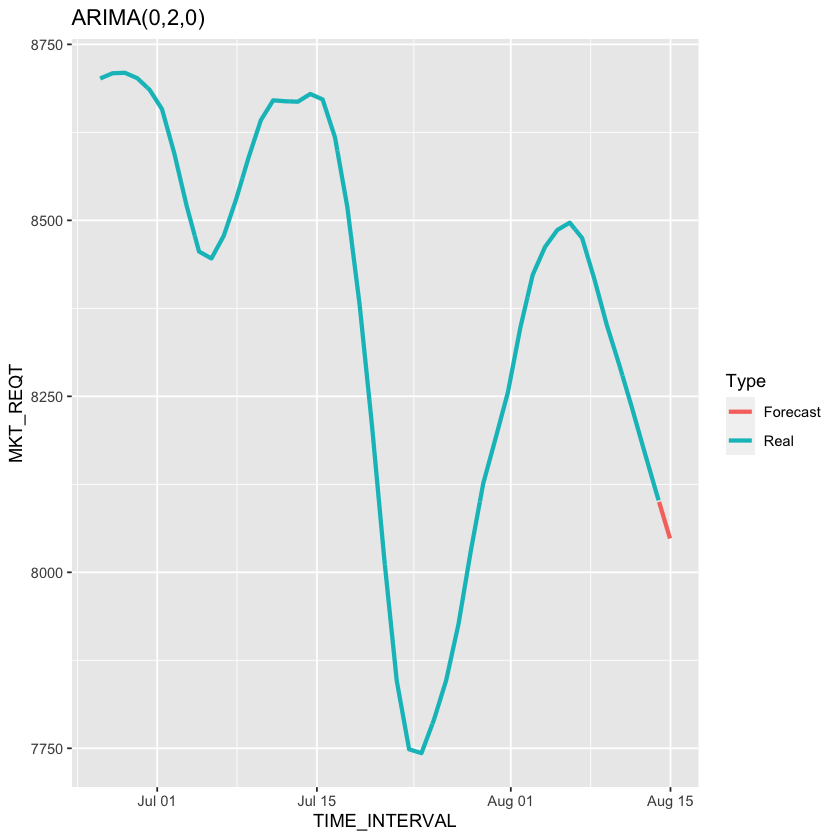

In [206]:
trend_data <- data.table(MKT_REQT = c(decomp_ts[,2], trend_for),
                         TIME_INTERVAL = c(data_train$TIME_INTERVAL, data_test$TIME_INTERVAL),
                         Type = c(rep("Real", nrow(data_train)), rep("Forecast",
                                                                     nrow(data_test))))
 
ggplot(trend_data, aes(TIME_INTERVAL, MKT_REQT, color = Type)) +
  geom_line(size = 1.2) +
  labs(title = paste(trend_fit))

In [209]:
# Add lag feature
N <- nrow(data_train)
window <- (N / period) - 1 # number of days in train set minus lag
 
new_MKT_REQT <- rowSums(decomp_ts[, c(1,3)]) # detrended load
lag_seas <- decomp_ts[1:(period*window), 1] # seasonal part of time series as lag feature
 
matrix_train <- data.table(MKT_REQT = tail(new_MKT_REQT, window*period),
                           fuur[(period + 1):N,],
                           Lag = lag_seas)

In [210]:
head(matrix_train)

MKT_REQT,S1-24,C1-24,S2-24,C2-24,S1-168,C1-168,S2-168,C2-168,Lag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-470.1428,0.2588190,0.9659258,0.5000000,0.8660254,0.8045978,0.5938202,0.9555728,-0.2947552,-346.6269
-719.2230,0.5000000,0.8660254,0.8660254,0.5000000,0.8262388,0.5633201,0.9308737,-0.3653410,-638.9261
-988.1449,0.7071068,0.7071068,1.0000000,0.0000000,0.8467242,0.5320321,0.9009689,-0.4338837,-904.8643
-1254.7294,0.8660254,0.5000000,0.8660254,-0.5000000,0.8660254,0.5000000,0.8660254,-0.5000000,-1109.9838
-1456.9022,0.9659258,0.2588190,0.5000000,-0.8660254,0.8841154,0.4672686,0.8262388,-0.5633201,-1237.1313
-1710.1593,1.0000000,0.0000000,0.0000000,-1.0000000,0.9009689,0.4338837,0.7818315,-0.6234898,-1341.9789


In [211]:
# Accuracy MAPE - Mean Absolute Percentage Error
mape <- function(real, pred){
  return(100 * mean(abs((real - pred)/real)))
}


## RPART

In [212]:
tree_1 <- rpart(MKT_REQT ~ ., data = matrix_train)


In [213]:
tree_1$variable.importance


Lag     S1-24    S1-168     C1-24     S2-24     C2-24    C2-168    S2-168 
551671375 530809911 198491989 179980249  84011521  63647555  52135692  36623745 
   C1-168 
 31529369

In [214]:
paste("Number of splits: ", tree_1$cptable[dim(tree_1$cptable)[1], "nsplit"])


[1] "Number of splits:  9"

In [218]:
install.packages("rpart.plot")
library(rpart.plot)



The downloaded binary packages are in
	/var/folders/47/k_hjs6l952v72vlq22ljz29w0000gn/T//RtmptCLiw5/downloaded_packages


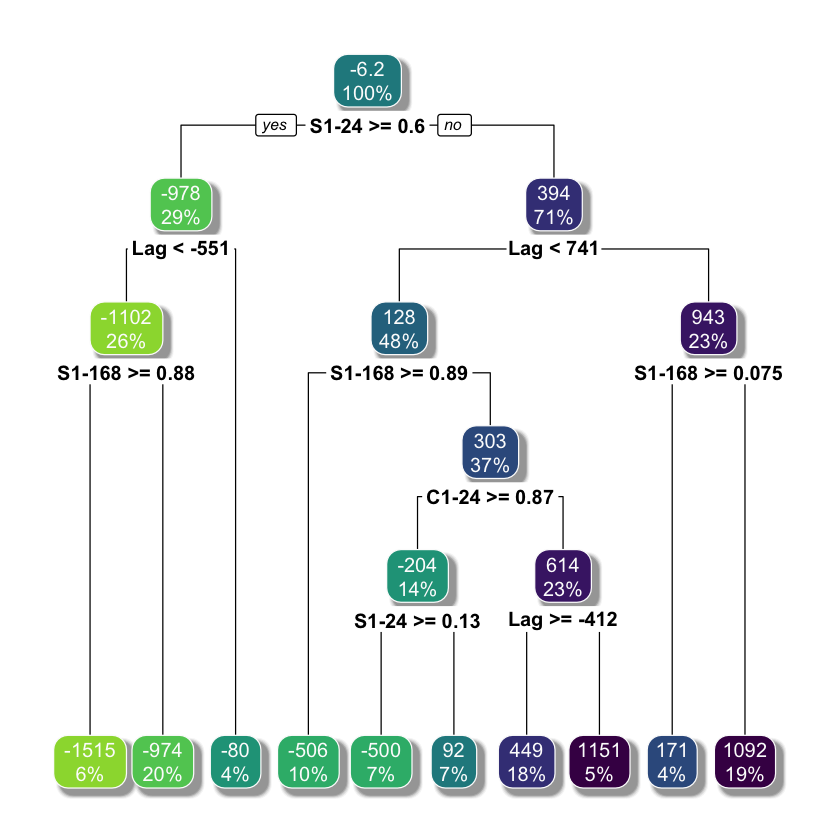

In [219]:
rpart.plot(tree_1, digits = 2, 
           box.palette = viridis::viridis(10, option = "D", begin = 0.85, end = 0), 
           shadow.col = "grey65", col = "grey99")


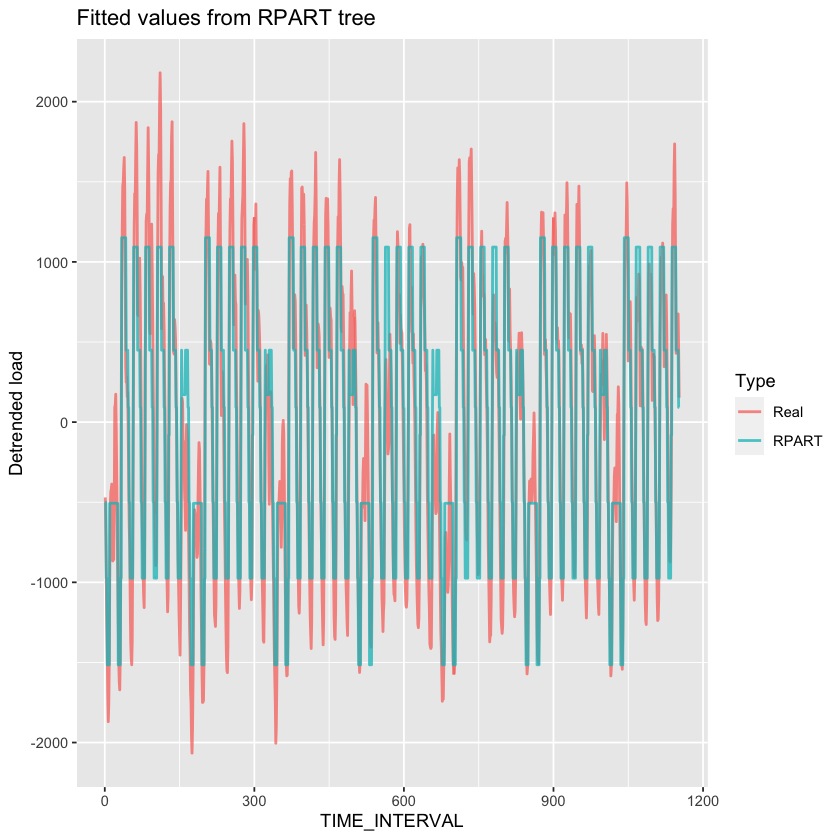

In [220]:
datas <- data.table(MKT_REQT = c(matrix_train$MKT_REQT,
                             predict(tree_1)),
                    TIME_INTERVAL = rep(1:length(matrix_train$MKT_REQT), 2),
                    Type = rep(c("Real", "RPART"), each = length(matrix_train$MKT_REQT)))
 
ggplot(datas, aes(TIME_INTERVAL, MKT_REQT, color = Type)) +
  geom_line(size = 0.8, alpha = 0.75) +
  labs(y = "Detrended load", title = "Fitted values from RPART tree")

In [222]:
mape(matrix_train$MKT_REQT, predict(tree_1))


[1] 559.0849

## Improvment

In [224]:
tree_2 <- rpart(MKT_REQT ~ ., data = matrix_train,
                control = rpart.control(minsplit = 2,
                                        maxdepth = 30,
                                        cp = 0.000001))

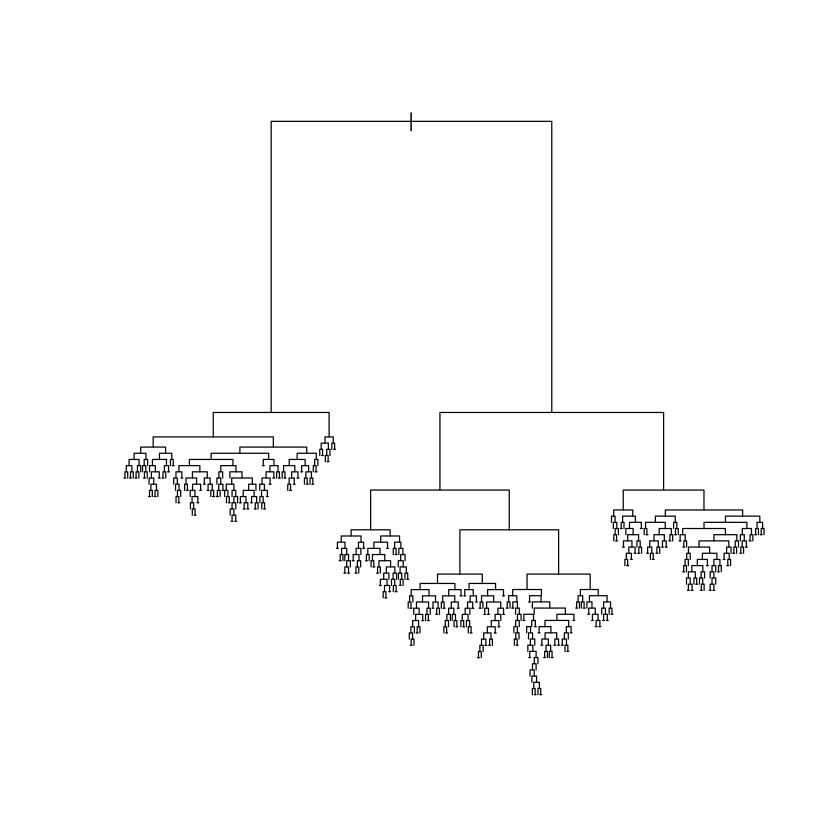

In [225]:
plot(tree_2, compress = TRUE)

In [226]:
tree_2$cptable[dim(tree_2$cptable)[1], "nsplit"] # Number of splits


[1] 465

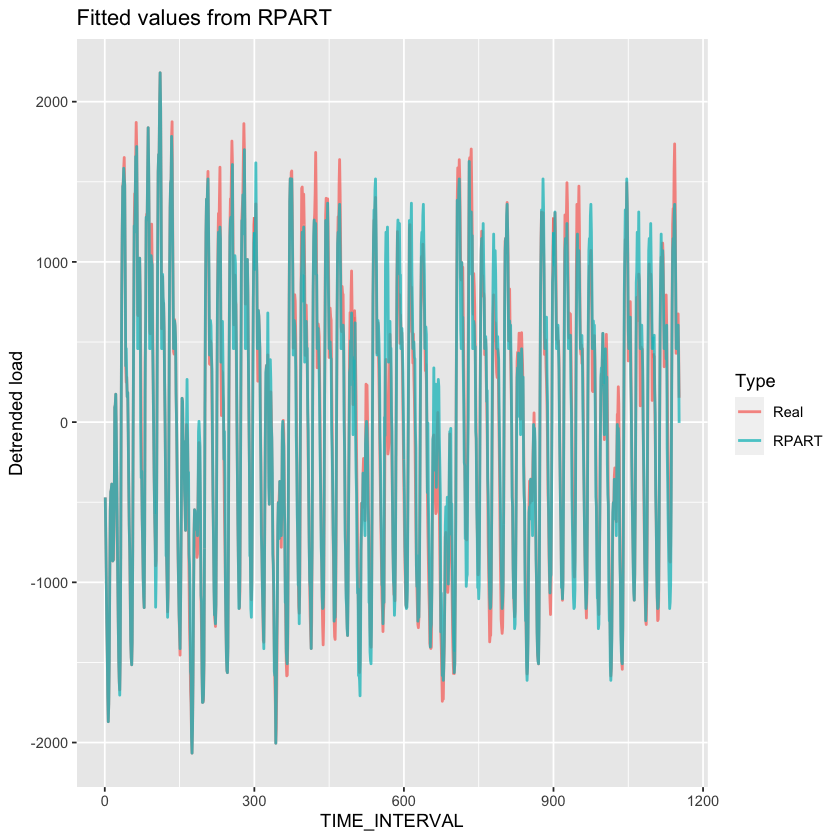

In [229]:
datas <- data.table(MKT_REQT = c(matrix_train$MKT_REQT,
                             predict(tree_2)),
                    TIME_INTERVAL = rep(1:length(matrix_train$MKT_REQT), 2),
                    Type = rep(c("Real", "RPART"), each = length(matrix_train$MKT_REQT)))
 
ggplot(datas, aes(TIME_INTERVAL, MKT_REQT, color = Type)) +
  geom_line(size = 0.8, alpha = 0.75) +
  labs(y = "Detrended load", title = "Fitted values from RPART")

In [230]:
mape(matrix_train$MKT_REQT, predict(tree_2))

[1] 68.93864

## Add trend forecast

In [231]:
test_lag <- decomp_ts[((period*window)+1):N, 1]
fuur_test <- fourier(data_msts, K = c(K, K), h = period)
 
matrix_test <- data.table(fuur_test,
                          Lag = test_lag)

In [232]:
for_rpart <- predict(tree_2, matrix_test) + trend_for

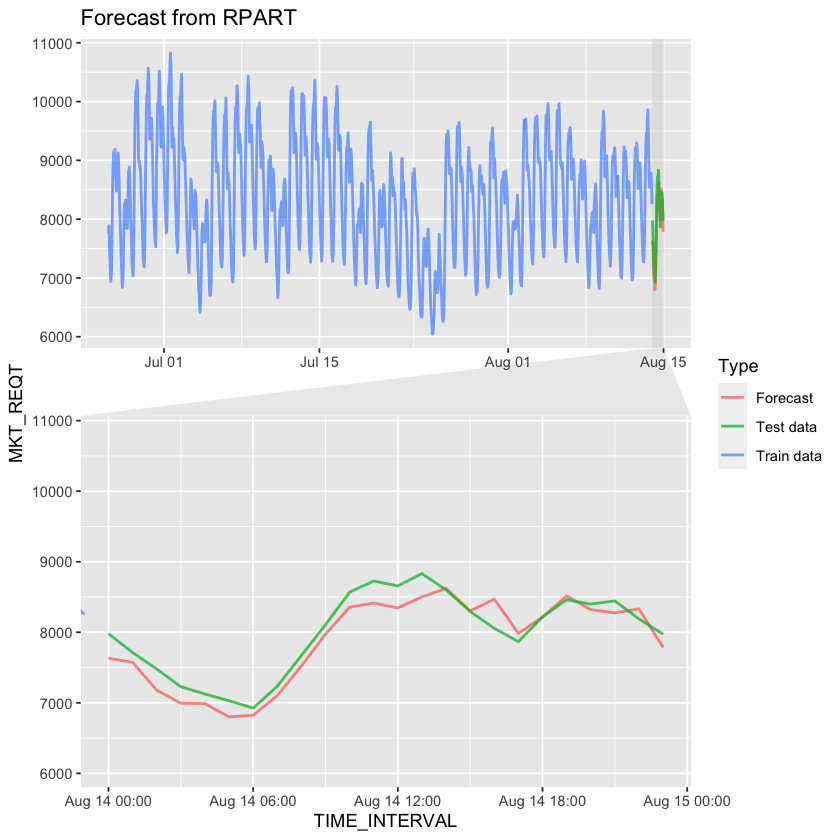

In [239]:
data_for <- data.table(MKT_REQT = c(data_train$MKT_REQT, data_test$MKT_REQT, for_rpart),
                       TIME_INTERVAL = c(data_train$TIME_INTERVAL, rep(data_test$TIME_INTERVAL, 2)),
                       Type = c(rep("Train data", nrow(data_train)),
                                rep("Test data", nrow(data_test)),
                                rep("Forecast", nrow(data_test))))
 
ggplot(data_for, aes(TIME_INTERVAL, MKT_REQT, color = Type)) +
  geom_line(size = 0.8, alpha = 0.75) +
  facet_zoom(x = TIME_INTERVAL %in% data_test$TIME_INTERVAL, zoom.size = 1.2) +
  labs(title = "Forecast from RPART")